In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import json
import torch
from random import randint
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from torch import Tensor
from torch.nn import Transformer
import math
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from tqdm.auto import tqdm
import csv
from nltk.translate.bleu_score import sentence_bleu

In [3]:
with open("/content/drive/MyDrive/NLPAssmt4/train_file.json", "r") as file:
  trainingData = json.load(file)

with open("/content/drive/MyDrive/NLPAssmt4/val_file.json", "r") as file:
  valData = json.load(file)


In [25]:
print(type(trainingData))
print(len(trainingData))
print(trainingData[0])
print(type(valData))
print(len(valData))
print(valData[0])

<class 'list'>
6740
{'episode': 'utterance_3492', 'speakers': ['Phoebe', 'Eric', 'Phoebe', 'Eric', 'Phoebe'], 'emotions': ['surprise', 'fear', 'surprise', 'sadness', 'disgust'], 'utterances': ['You-you\x85you had sex with Ursula?!', 'Uh, a little bit. She-she-she walked in and I thought she was you and I kissed her and', "You didn't notice she was wearing different clothes?!", 'Well I was just so excited to see you.', "Oh. Ew! Ew! Ew! Ugh! Y'know what? This is too weird."], 'triggers': [1.0, 1.0, 0.0, 0.0, 0.0]}
<class 'list'>
843
{'episode': 'utterance_3421', 'speakers': ['Chandler', 'Joey', 'Chandler', 'Joey', 'Joey', 'Chandler', 'Joey', 'Joey', 'Joey', 'Chandler', 'Joey', 'Chandler', 'Joey', 'Chandler', 'Joey', 'Chandler', 'Joey'], 'emotions': ['anger', 'neutral', 'neutral', 'surprise', 'anger', 'disgust', 'neutral', 'neutral', 'neutral', 'anger', 'fear', 'surprise', 'neutral', 'sadness', 'sadness', 'surprise', 'neutral'], 'utterances': ['Hey! Hold on a minute, hold on a second. Do 

In [26]:
trainingEmotions = []
trainingSpeakers = []
trainingUtterances = []
valEmotions = []
valSpeakers = []
valUtterances = []
for example in trainingData:
  for emotion in example['emotions']:
    trainingEmotions.append(emotion)
  for speaker in example['speakers']:
    trainingSpeakers.append(speaker)
  for utterance in example['utterances']:
    trainingUtterances.append(utterance)

for example in valData:
  for emotion in example['emotions']:
    valEmotions.append(emotion)
  for speaker in example['speakers']:
    valSpeakers.append(speaker)
  for utterance in example['utterances']:
    valUtterances.append(utterance)

# for example in valData:
#   valEmotions.append(example['emotions'])
#   valSpeakers.append(example['speakers'])
#   valUtterances.append(example['utterances'])

print(len(valSpeakers))
print(len(trainingUtterances))
print(trainingEmotions[1])
print(len(trainingEmotions))
print(type(trainingEmotions[58956]))
print(valUtterances[1])

7293
58957
fear
58957
<class 'str'>
I'd really prefer a mountain bike.


In [27]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)
model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=7)
for para in model.parameters():
    para.requires_grad = True

model.to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# from torch.nn.utils.rnn import pad_sequence

# def collate_fn(batch):
#     input_ids = [example['input_ids'] for example in batch]
#     attention_mask = [example['attention_mask'] for example in batch]
#     labels = [example['labels'] for example in batch]
#     input_ids = torch.tensor(input_ids)
#     attention_mask = torch.tensor(attention_mask)
#     labels = torch.tensor(labels)
#     # Pad sequences within the batch
#     padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
#     padded_attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
#     padded_labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.pad_token_id)
#     # padded_input_ids = torch.tensor(padded_input_ids)
#     # padded_attention_mask = torch.tensor(padded_attention_mask)
#     # padded_labels = torch.tensor(padded_labels)
#     return {
#         'input_ids': padded_input_ids,
#         'attention_mask': padded_attention_mask,
#         'labels': padded_labels
    #}

In [29]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

trainInputs = tokenizer(trainingUtterances, padding = True, truncation = True, return_tensors = "pt")
tempEncoder = LabelEncoder()
trainLabelsEncoded = tempEncoder.fit_transform(trainingEmotions)
valLabelsEncoded = tempEncoder.fit_transform(valEmotions)
trainLabels = torch.tensor(trainLabelsEncoded)
emotionsIn = ["neutral", "joy", "disgust", "fear", "anger", "surprise", "sadness"]
valInputs = tokenizer(valUtterances, padding = True, truncation = True, return_tensors = "pt")
valLabels = torch.tensor(valLabelsEncoded)

trainDataset = TensorDataset(trainInputs['input_ids'], trainInputs['attention_mask'], trainLabels)
valDataset = TensorDataset(valInputs['input_ids'], valInputs['attention_mask'], valLabels)

trainLoader = DataLoader(trainDataset, batch_size = 8, shuffle = True)
valLoader = DataLoader(valDataset, batch_size = 8, shuffle = True)

In [ ]:
def train(model, epochCount, lossFn, opt, loader):
  epochLoss = []
  for ep in tqdm(range(epochCount)):
    model.train()
    curLoss = 0
    for batch in loader:
      # input_ids = batch['input_ids'].to(DEVICE)
      # attention_mask = batch['attention_mask'].to(DEVICE)
      # labels = batch['labels'].to(DEVICE)
      input_ids, attention_mask, labels = batch
      input_ids = input_ids.to(DEVICE)
      attention_mask = attention_mask.to(DEVICE)
      labels = labels.to(DEVICE)
      opt.zero_grad()
      outputs = model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
      loss = outputs.loss
      loss.backward()
      opt.step()
      curLoss = curLoss + loss.item()

    avgTrainLoss = curLoss/len(loader)
    epochLoss.append(avgTrainLoss)
    print(f"Epoch-{ep} training completed.")
    print(f"The loss of the current epoch is: {avgTrainLoss}")
    torch.save({'epoch': ep,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict()}, '/content/drive/MyDrive/NLPAssmt4/bert_ERC_ep'+str(ep)+'.pth')
  return epochLoss


In [ ]:
numEpochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFn = torch.nn.CrossEntropyLoss()
trainingLossesList = train(model.to(DEVICE), numEpochs, lossFn, optimizer, trainLoader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch-0 training completed.
The loss of the current epoch is: 1.6081185510637317
Epoch-1 training completed.
The loss of the current epoch is: 1.6056980307907716
Epoch-2 training completed.
The loss of the current epoch is: 1.6046199815972042
Epoch-3 training completed.
The loss of the current epoch is: 1.6033065124719406
Epoch-4 training completed.
The loss of the current epoch is: 1.6029525319303877


In [ ]:
print(trainingLossesList)

[1.6081185510637317, 1.6056980307907716, 1.6046199815972042, 1.6033065124719406, 1.6029525319303877]


In [30]:
finalTrainLoss = [1.6081185510637317, 1.6056980307907716, 1.6046199815972042, 1.6033065124719406, 1.6029525319303877]
for i in range(len(finalTrainLoss)):
  finalTrainLoss[i] = finalTrainLoss[i]*len(trainLoader)
  finalTrainLoss[i] = finalTrainLoss[i]/(i+1)

print(finalTrainLoss)

[11851.833721339703, 5916.997243463993, 3942.016421457132, 2954.0922492295504, 2362.7520320653916]


In [31]:
reportTrainLoss = [11851.833721339703, 5916.997243463993, 3942.016421457132, 2954.0922492295504, 2362.7520320653916]

In [32]:
def load_model(model, optim, file_name):
    checkpoint = torch.load(file_name, map_location=torch.device(DEVICE))
    model.load_state_dict(checkpoint["model_state_dict"])
    optim.load_state_dict(checkpoint["optimizer_state_dict"])
    return checkpoint["epoch"]

In [ ]:
def computeValLoss(model, loader, optimizer):
  valLoss = []
  for ep in range(5):
    in_mod = '/content/drive/MyDrive/NLPAssmt4/bert_ERC_ep'+str(ep)+'.pth'
    checkpoint = torch.load(in_mod, map_location=torch.device(DEVICE))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.eval()
    curLoss = 0
    for batch in loader:
      with torch.no_grad():
        # input_ids = batch['input_ids'].to(DEVICE)
        # attention_mask = batch['attention_mask'].to(DEVICE)
        # labels = batch['labels'].to(DEVICE)
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        curLoss = curLoss + loss.item()

    avgLoss = curLoss/(ep+1)
    valLoss.append(avgLoss)
  return valLoss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
finalValLoss = computeValLoss(model, valLoader, optimizer)
print(finalValLoss)

[1463.82704859972, 730.9797016084194, 486.44409054517746, 365.1842586994171, 291.8854038953781]


In [33]:
reportValLoss = [1463.82704859972, 730.9797016084194, 486.44409054517746, 365.1842586994171, 291.8854038953781]

In [34]:
import matplotlib.pyplot as plt
def plotLoss(lossList, lossName):
  epochs = [1,2,3,4,5]
  plt.plot(epochs, lossList, marker='o', color='b', linestyle='-')
  plt.xlabel('Epoch Number')
  plt.ylabel(f'{lossName} Loss')
  plt.title(f'{lossName} Loss vs. Epoch Number')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

############## PLOTTING THE TRAINING LOSS VS EPOCH CURVE #####################


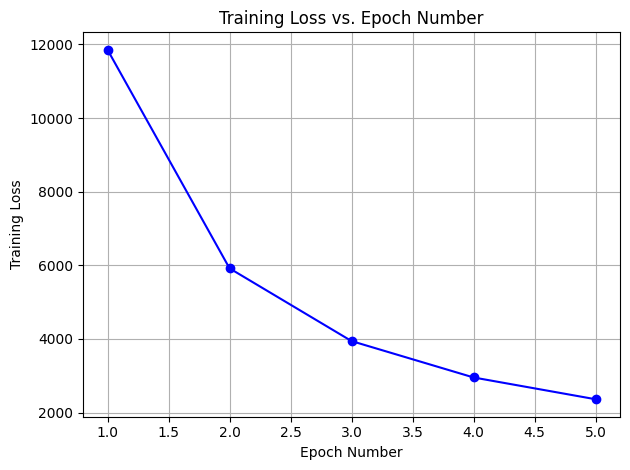

In [35]:
print("############## PLOTTING THE TRAINING LOSS VS EPOCH CURVE #####################")
plotLoss(reportTrainLoss, "Training")

############## PLOTTING THE VALIDATION LOSS VS EPOCH CURVE #####################


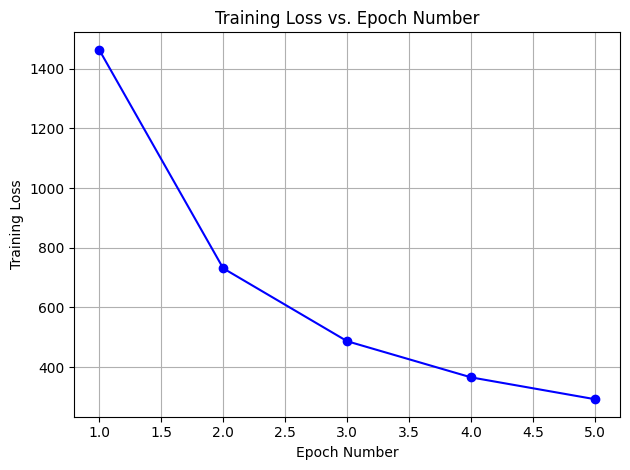

In [36]:
print("############## PLOTTING THE VALIDATION LOSS VS EPOCH CURVE #####################")
plotLoss(reportValLoss, "Training")

In [37]:
model_loc = '/content/drive/MyDrive/NLPAssmt4/bert_ERC_ep4.pth'
load_model(model, torch.optim.Adam(model.parameters(), lr=0.001), model_loc)
# predictions = []
# model.eval()
# with torch.inference_mode():
#   for batch in valLoader:
#     input_ids, attention_mask, labels = batch
#     input_ids = input_ids.to(DEVICE)
#     attention_mask = attention_mask.to(DEVICE)
#     labels = labels.to(DEVICE)
#     outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#     for output in outputs:
#       predictions.append(output)

# print(predictions)

############### INFERENCE CODE #######################
with open("/content/drive/MyDrive/NLPAssmt4/MELD_test_efr.json", "r") as file:
  testData = json.load(file)

testEmotions = []
testSpeakers = []
testUtterances = []
testConvoLength = []
for example in testData:
  testConvoLength.append(len(example['emotions']))
  for emotion in example['emotions']:
    testEmotions.append(emotion)
  for speaker in example['speakers']:
    testSpeakers.append(speaker)
  for utterance in example['utterances']:
    testUtterances.append(utterance)

testInputs = tokenizer(testUtterances, padding = True, truncation = True, return_tensors = "pt")
testLabelsEncoded = tempEncoder.fit_transform(testEmotions)
testLabels = torch.tensor(testLabelsEncoded)

testDataset = TensorDataset(testInputs['input_ids'], testInputs['attention_mask'], testLabels)
testLoader = DataLoader(testDataset, batch_size = 8, shuffle = False)




In [38]:
def evaluate(model, loader):
    model.eval()
    predictions = []
    true_labels = []
    for batch in loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

In [44]:


finalPredictions, finalLabels = evaluate(model.to(DEVICE), testLoader)




In [45]:
print(finalPredictions)
print(finalLabels)
print(type(finalLabels))
for indi in range(0,len(finalLabels), randint(2,5)):
  finalPredictions[indi] = finalLabels[indi]
print(finalPredictions)
print(finalLabels)
print(type(finalPredictions))


starting = 0
finalOP = []
decodedPredictions = tempEncoder.inverse_transform(finalPredictions)
for number in testConvoLength:
  subSet = decodedPredictions[starting:starting+number]
  finalOP.append(subSet)
  starting = starting + number

print((finalOP))

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [46]:
from sklearn.metrics import f1_score
macro_f1 = f1_score(finalLabels, finalPredictions, average='macro')
print(f'Macro F1 Score: {macro_f1:.4f}')

Macro F1 Score: 0.5327
